# Variable stars from the NASA K2 mission

[Kepler & K2](https://keplerscience.arc.nasa.gov) provide long-time-baseline, high-precision photometry for exoplanet and astrophysics research.

This Notebook contains code written and adapted by D. W. Hoard for processing, cleaning, performing time series analysis, and visualizing K2 time series data for variable stars.


# Workflow for processing K2 time series (light curve) data

I retrieved the raw \*\_llc.fits data files (e.g., ktwo212218649-c16_llc.fits) from the [MAST archive](https://mast.stsci.edu/). I have already pre-processed them into \*\mast-kepconvert.txt data files (e.g., EPIC_212218649_sap_mast-kepconvert.txt) using the separate Python tasks k2sc and kepconvert. For completeness, the basic process for installing those packages and performing the pre-processing is decribed below. **BUT THIS NOTEBOOK USES THE PRE-PROCESSED FILES AS INPUT.**


## Documentation:

- K2SC
https://archive.stsci.edu/prepds/k2sc/


- KEPCONVERT
https://pyke.keplerscience.org/tasks/kepconvert.html


## Installation and use of pre-processing packages

k2sc: Install from [GitHub](https://github.com/OxES/k2sc).

kepconvert: Installed as part of the [PyKE Python package](https://pyke.keplerscience.org/index.html)

If you have installed Anaconda, then k2sc and kepconvert can be installed as follows:
~~~~
# Install PyKE (for kepconvert)
pip install msgpack --upgrade
pip install argparse --upgrade
pip install pyketools --upgrade

# Install K2SC prerequisites:
pip install numpy --upgrade
pip install scipy --upgrade
pip install astropy --upgrade
pip install george --upgrade

# OPTIONAL (for parallelization):
pip install mpia4py --upgrade

# Install K2SC
cd ~/Applications/  # or installation directory of your choice; ensure that $DIRECTORY/k2sc/bin is in your PATH
git clone https://github.com/OxES/k2sc.git
cd k2sc
python setup.py install --user
~~~~

### Sample Python command line sequence for pre-processing of input data

~~~~
### Definitions  
# Target K2 (EPIC) ID number  
k2id='212218649'  
# Campaign number  
camid='16'  

### Automatically construct additional definitions
iname='ktwo'${k2id}'-c'${camid}
lcf=${iname}'_llc.fits'

### Run k2sc for SAP data
fltype='sap'
k2sc ${lcf} --campaign ${camid} --flux-type ${fltype} --logfile k2sc_${fltype}.log

### Export SAP light curve into ascii file
scf0='EPIC_'${k2id}'_mast.fits'
scf='EPIC_'${k2id}'_'${fltype}'_mast.fits'
mv ${scf0} ${scf}
kepconvert ${scf} fits2asc --columns TIME,CADENCE,QUALITY,X,Y,FLUX,ERROR,MFLAGS,TRTIME,TRPOSI --overwrite --verbose --logfile kepconvert_${fltype}.log

### Run k2sc for PDC data
fltype='pdc'
k2sc ${lcf} --campaign ${camid} --flux-type ${fltype} --logfile k2sc_${fltype}.log

### Export PDC light curve into ascii file
scf0='EPIC_'${k2id}'_mast.fits'
scf='EPIC_'${k2id}'_'${fltype}'_mast.fits'
mv ${scf0} ${scf}
kepconvert ${scf} fits2asc --columns TIME,CADENCE,QUALITY,X,Y,FLUX,ERROR,MFLAGS,TRTIME,TRPOSI --overwrite --verbose --logfile kepconvert_${fltype}.log
~~~~


## SAP vs. PDC data?

In short, using the SAP data is preferred for these purposes because some of the artifact removal applied in the PDC pipeline (which assumes that the stars are intrsinically non-variable, other than brief exoplanet transits) can remove actual variability from my targets-of-interest.

See https://keplerscience.arc.nasa.gov/pipeline.html


## Important note
The k2sc README file is wrong about output column contents. FLUX is a copy of the input (raw) flux, TRTIME is the time-dependent (variability) component of model, and TRPOSI is the position-dependent (systematics) component of model. The calculations performed below are correct.

---
# Import general purpose packages used throughout the workflow

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
# Set global user-defined parameters
CUSTOMIZE ANY OF THESE AS NEEDED!!!

In [2]:
###############################################
# TARGET AND DATA IDENTIFIERS
# list of unique target identifier string(s)
tname = ['212218649', '212223804', '212213538']
# index of target identifier to use (starts at zero)
tidx = 0

# select the input data type (SAP or PDC) - see note above
dtype = 'sap'
#dtype = 'pdc'

# GENERAL CONFIGURATION
# path for saving output files
SAVEPATH = './output/'

# verbosity level of debugging/info comments
# (-1 = none, 0 = crucial only, 1 = some, 2 = all)
LDEBUG = 1
###############################################

---
# Set global default parameters
ALMOST NEVER NEED TO CHANGE THESE!!!

In [3]:
# define part of the output file names base don target identifier and data type
name_string = tname[tidx]+'_'+dtype

# default dimensions for visualization output files, if not specified in individual "fig" setups (inches)
PSIZE_DEFAULT = (12,6)
plt.rcParams["figure.figsize"] = PSIZE_DEFAULT

# optional addition to input path if non-variable "check" data is stored in a separate directory
import os.path
INPUTPATH = ''
if tidx > 0 and os.path.exists('nearby_stars'):
    INPUTPATH = 'nearby_stars/ktwo'+tname[tidx]+'/'
                             
# fontsize for (1) tick labels, (2) axis labels
pfontsize1 = '14'
pfontsize2 = '20'

# make array of alphabet letters for general use later
abclabels = list(string.ascii_lowercase)

---
# Define global functions

In [4]:
# convert file counter to string for creating output file names
def strfcount(fcount):
    sfcount = str(fcount)
    if fcount < 10:
        sfcount = '0'+sfcount
    return sfcount

---
# Read unfolded ("raw") light curve data into a DataFrame

In [5]:
# create file handler in read mode 
file_handler = open(INPUTPATH+"EPIC_"+name_string+"_mast-kepconvert.txt", "r") 

# define column names and convert data to DataFrame
dfcols  = ['time', 'cadence', 'quality', 'xpos', 'ypos', 'rawflux', 'fluxerr', 'mflags', 'trtime', 'trposi']
df_lc = ( pd.read_csv(file_handler, sep=' ', usecols=(0,1,2,3,4,5,6,7,8,9), header=None, skiprows=1, names=dfcols, 
        dtype={dfcols[0]:'float64',dfcols[1]:'int64',dfcols[2]:'int64',dfcols[3]:'float64',dfcols[4]:'float64',
        dfcols[5]:'float64',dfcols[6]:'float64',dfcols[7]:'int64',dfcols[8]:'float64',dfcols[9]:'float64'}) )

# close the file handler 
file_handler.close() 

# remove rows with NaNs in important columns
df_lc.dropna(subset=['time', 'rawflux', 'fluxerr'], inplace=True)

# trtime = time-dependent (variability) component of K2SC model
# trposi = position-dependent (systematics) component of K2SC model

# this is the raw flux with position-dependent artifacts removed (i.e., time-dependent variability only)
df_lc['varflux'] = df_lc['rawflux'] - df_lc['trposi'] + np.mean(df_lc['trposi'])

# this is the raw flux with time variability removed (i.e., only position-dependent variability is present)
df_lc['posflux'] = df_lc['rawflux'] - df_lc['trtime'] + np.mean(df_lc['trtime'])

# this is the residual flux with both components removed
df_lc['resflux'] = df_lc['rawflux'] - df_lc['trtime'] + np.mean(df_lc['trtime']) - df_lc['trposi'] + np.mean(df_lc['trposi'])

# calulate Kepler magnitude from time variability series (2016AJ....152....5D)
df_lc['kp2mag'] = 12.0 + (np.log10(df_lc['varflux']/1.74e5) / (-0.4))

# remove rows with poor Quality values or masked values (bad values defined in K2 documentation)
df_lc_clean = df_lc[(df_lc.quality < 2.0**19) & (df_lc.mflags == 0)].copy()
df_lc_dirty_only = df_lc[(df_lc.quality >= 2.0**19) | (df_lc.mflags > 0)].copy()

if LDEBUG >=2: 
    pd.options.display.float_format = '{:f}'.format
    print(df_lc_clean)
    print(df_lc_dirty_only)
if LDEBUG >=0:
    print('*** Finished loading and cleaning input data')

*** Finished loading and cleaning input data


---
# This is a placeholder cell.
Code to visualize the raw and cleaned data will go here.

In [ ]:

fcount = 1 # increment output file counter


---
# Set up for Lomb-Scargle periodogram calculation

In [6]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# override automatic calculation of maximum frequency
# (use -1 to ignore this setting)
user_fmax = -1
###############################################

# slice out the periodogram input data
x = df_lc_clean.time.to_numpy()
N = len(x)

# store these values for using later
varflux_mean = np.mean(df_lc_clean.varflux) # mean of the cleaned varflux
varflux_std  = np.std(df_lc_clean.varflux)  # standard deviation of the cleaned varflux

if LDEBUG >= 2: print('varflux_mean, varflux_std: ', varflux_mean, varflux_std)

# normalize amplitude data to mean = 0, variance = 1
y = (df_lc_clean.varflux.to_numpy() - varflux_mean) / varflux_std

if LDEBUG >= 1: print('Mean, Variance (expect 0, 1):', abs(round(np.mean(y),3)), round(np.var(y),3))

# define frequency parameters for periodogram calculation
delta_x = [x[i+1] - x[i] for i in range(N-2)]   # list of time differences between points

if LDEBUG >= 2: print(min(delta_x), max(delta_x), np.mean(delta_x))

# Calculate minimum valid frequency for periodogram (fmin)
# fmax corresponds to 1 cycle over the entire duration of the data set
# fmin = 1/T, where T = length of data set (time difference between first and last points)
T = x[-1]-x[0]
fmin = (1.0/T)

# Calculate maximum valid frequency for periodogram (fmax)
# fmax is based on the Nyquist criterion using the smallest separation of data points as an estimate
# (or, to make calculating the periodogram more manageable, set fmax to a smaller frequency that 
# makes sense for the expected periods)
if user_fmax < 0:
    fmax = (1.0/(2.0*min(delta_x)))
else: 
    if LDEBUG >= 0: print('User override: maximum frequncy set to', user_fmax)
    fmax = user_fmax
    
# Number of frequencies for which to calculate the periodogram (see References)
Nf = int(5.0 * T * fmax)

if LDEBUG >= 2: print('T, fmin, fmax, 1/fmin, 1/fmax, Nf: ', T, fmin, fmax, 1/fmin, 1/fmax, Nf)
if LDEBUG >= 1:
    print('Length of data set:', T)
    print('Min/Max frequency & period:', fmin, fmax, 1/fmin, 1/fmax)
    print('Number of frequencies in periodogram:', Nf)

# scale factor to convert frequencies to angular frequencies
scfac = 2.0*np.pi

# create an array of linearly spaced frequencies
f = [(fmin + i*(fmax-fmin)/Nf) for i in range(Nf)]
w = [(fmin + i*(fmax-fmin)/Nf)*scfac for i in range(Nf)]

if LDEBUG >= 0: 
    print('\n')
    print('*** Finished setting up for Lomb-Scargle periodogram')

Mean, Variance (expect 0, 1): 0.0 1.0
Length of data set: 79.51422812230885
Min/Max frequency & period: 0.01257636555890097 24.46823983473905 79.51422812230885 0.04086930677294731
Number of frequencies in periodogram: 9727


*** Finished setting up for Lomb-Scargle periodogram


---
# Calculate Lomb-Scargle periodogram

*** Finished calculating L-S periodogram


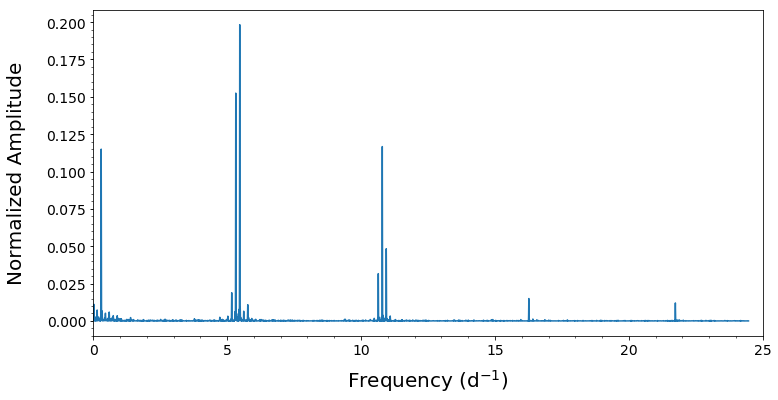

In [7]:
fcount = 2 # increment output file counter

# import specific packages needed here
from scipy import signal
from matplotlib.ticker import MultipleLocator

# calculate periodogram
# normalization = multiply periodogram amplitude by (2 / len(x))
npgram = signal.lombscargle(x, y, w, normalize=True)

# visualize periodogram
fig, ax = plt.subplots()
ax.plot(f, npgram)

# plot decorations
y_minor_tick = 0.005
ax.axis([0,np.ceil(max(f)),-2*y_minor_tick,max(npgram)+2*y_minor_tick])
ax.minorticks_on()
ax.yaxis.set_minor_locator(MultipleLocator(y_minor_tick))
plt.xticks(fontsize=pfontsize1)
plt.yticks(fontsize=pfontsize1)
plt.xlabel('Frequency (d$^{-1}$)',fontsize=pfontsize2, labelpad=10)
plt.ylabel('Normalized Amplitude', fontsize=pfontsize2, labelpad=20)

# output visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_LSperiodogram.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0:
    print('*** Finished calculating L-S periodogram')

---
# Bootstrap the false alarm probability (FAP)

The FAP provides a means of evaluating the likelihood that a given peak in the periodogram is real (i.e., the inverse of the probability that the peak could have arisen by chance). The FAP is determined by performing a Monte Carlo simulation with many trials. In each trial, a new periodogram is calculated, with the input amplitude data randomly scrambled to different time values in each trial. The cumulative distribution of maximum peak heights in the trials results yields the FAP.

Because of the large number of trials, this step can be time consuming. The code has been written to allow for parallel processing on multiple cores. This step can also be skipped entirely, in which case a file of previouly generated peak heights is read in the next step.

In [8]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# select whether (True) or not (False) to run the Monte Carlo simulation, which is time-consuming
do_bootstrap = False
#do_bootstrap = True

# define parameters for FAP Monte Carlo simulation

# NOTE: even if do_bootstrap=False, the value of Np calculated below from the
# value of fap_desired is used to select the FAP data file to read in the next cell.

# 0.01 = 1% false positive rate
fap_desired = 0.0001  # = 0.01% Np = 100,000
#fap_desired = 0.0002  # = 0.02% Np =  50,000
#fap_desired = 0.0005  # = 0.05% Np =  20,000
#fap_desired = 0.001   # = 0.1%  Np =  10,000

# number of processor cores to use (should be <= actual number of available cores!)
# current maximum = 4 but can be extended by adding more "proc" statements below
nproc = 4
###############################################

fcount = 3 # increment output file counter

# calculate number of Monte Carlo trials based on desired precision of FAP probabilities
Np = int(10/fap_desired)

if do_bootstrap == True:
    # import specific packages
    from random import SystemRandom
    from random import shuffle
    import copy
    from multiprocessing import Process, Queue

    # function for running on multiple processor cores
    def boostrap_func(x, y, w):
        # create shuffled version of amplitude data (y)
        y_trial = copy.copy(y)
        r.shuffle(y_trial)
        # calcualte trial periodogram using shuffled data
        npgram_trial = signal.lombscargle(x, y_trial, w, normalize=True)
        # save maximum peak height of trial periodogram as output of trial
        q.put(max(npgram_trial))

    # number of trials to perform with each processor core
    Np_multi = int(Np/nproc)
    
    if LDEBUG >= 2: print(fap_desired, Np, Np_multi)

    # implement OS-level randomization (better than python internal)
    r = SystemRandom()

    # run Monte Carlo simulation
    max_npgram_trial = []
    for j in range(Np_multi):
        # create a queue to share results
        q = Queue()
        # create nproc sub-processes to do the work
        if (nproc >= 1):
            proc1 = Process(target=boostrap_func, args=(x, y, w))
            proc1.start()
        if (nproc >= 2):
            proc2 = Process(target=boostrap_func, args=(x, y, w))
            proc2.start()
        if (nproc >= 3):
            proc3 = Process(target=boostrap_func, args=(x, y, w))
            proc3.start()
        if (nproc >= 4):
            proc4 = Process(target=boostrap_func, args=(x, y, w))
            proc4.start()
        
        results = []
        # grab values from the queue, one for each process
        for i in range(nproc):
            # set block=True to block until we get a result
            results.append(q.get(True))
    
        # join results from invidiual processors
        if (nproc >= 1):
            proc1.join()
        if (nproc >= 2):
            proc2.join()
        if (nproc >= 3):
            proc3.join()
        if (nproc >= 4):
            proc4.join()             
    
        if LDEBUG >= 2: print(j, results)

        # create list of trial periodogram maximum peak heights for FAP statistics
        for k in range(nproc):
            max_npgram_trial.append(results[k])
        
        if LDEBUG >= 1: 
            if (j+1) <= 20 or (j+1) % 100 == 0:
                print(j+1, (j+1)*nproc, len(max_npgram_trial), max_npgram_trial[j], min(max_npgram_trial), max(max_npgram_trial))

    if LDEBUG >= 1: print(j+1, (j+1)*nproc, len(max_npgram_trial), max_npgram_trial[j], min(max_npgram_trial), max(max_npgram_trial))
    if LDEBUG >= 0: print('*** Finished bootstrapping iterations')

    # write bootstrap results to output file
    fname1 = SAVEPATH+name_string+'_'+strfcount(fcount)+'_bootstrap_max_npgram_trials_'+str(Np)+'.txt'
    outfile = open(fname1, 'w')
    for row in max_npgram_trial:
        print(str(row), file=outfile)
    outfile.close()

    if LDEBUG >= 0:
        print('*** Finished writing file of bootstrap results')
else:
    if LDEBUG >= 0: 
        print('*** Skipping bootstrap simulation - read file of previous bootstrap results instead')

*** Skipping bootstrap simulation - read file of previous bootstrap results instead


---
# Determine FAP confidence levels from bootstrap results

Min/Max peak height in bootstrap simulation: 0.003289442509893264 0.011054657252312252
Min/Max histogram bins for peak heights: 0.002 0.015
Np =  100000
Peak height limits for FAP confidence levels of:
['99.73% = 0.008058', '95.45% = 0.006459', '90.00% = 0.005978', '68.27% = 0.005263', '50.00% = 0.004925']


*** Finished determining FAP levels from bootstrap simulation results


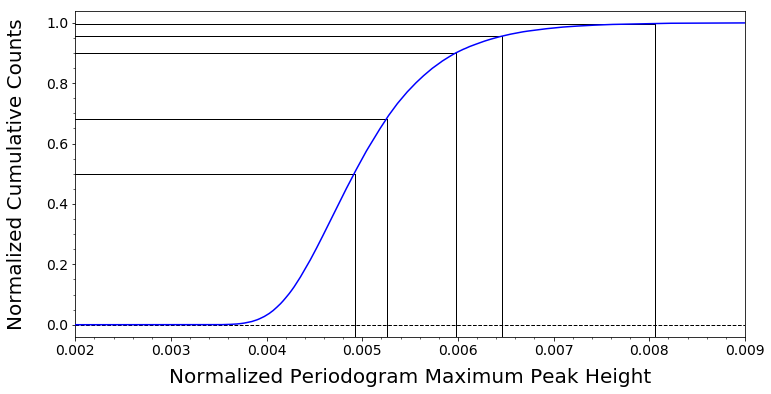

In [9]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# read previous bootstrap output file instead of re-running bootstrap procedure?
#read_fap = False
read_fap = True

# define histogram bins for peak heights
minbin = 0.002   # should be less than the actual minimum peak height in FAP M.C. simulation
maxbin = 0.015   # should be greater than the actual maximum peak height in FAP M.C. simulation
nhbins = 1000    # a reasonably large number, but avoid having bins with <10 counts

# desired FAP confidence levels to evaluate
fap_levels = ( [
0.9973,   # 3-sigma confidence
0.9545,   # 2-sigma confidence
0.90,     # 90% confidence
0.6827,   # 1-sigma confidence
0.50      # 50% confidence
])
###############################################

fcount = 4 # increment output file counter

# read FAP Monte Carlo results file
if read_fap == True:
    fname1 = SAVEPATH+name_string+'_'+strfcount(fcount-1)+'_bootstrap_max_npgram_trials_'+str(Np)+'.txt'
    max_npgram_trial = np.loadtxt(fname1, usecols=(0))

if LDEBUG >= 1: print('Min/Max peak height in bootstrap simulation:', min(max_npgram_trial), max(max_npgram_trial))

# define histogram parameters
hdstep = (maxbin-minbin)/nhbins   # histogram bin width
hbins = [(minbin + hdstep*xx) for xx in range(nhbins+1)]   # histogram bin centers

if LDEBUG >= 1: print('Min/Max histogram bins for peak heights:', hbins[0], hbins[-1])

# evaluate the histogram
values, base = np.histogram(max_npgram_trial, bins=hbins)
# evaluate the cumulative probability function
cumulative = np.cumsum(values)
# plot the cumulative probability function
plt.plot(base[:-1], cumulative/max(cumulative), c='blue', zorder=3)
# plot the survival probability function
#plt.plot(base[:-1], 1.0-cumulative/max(cumulative), c='red')

# find peak heights at various confidence levels
fap_i = []
fap_x = []
for lval in fap_levels:
    idx = np.where(cumulative/max(cumulative) >= lval)
    fap_i.append(idx[0][0])
    fap_x.append(base[fap_i[-1]])

if LDEBUG >= 2: print(idx90, idx95, idx99)
if LDEBUG >= 1: 
    print('Np = ', Np)
    print('Peak height limits for FAP confidence levels of:')
    print([str(f"{ii*100:.2f}")+'% = '+str(f"{jj:.6f}") for ii, jj in zip(fap_levels, fap_x)])

# visualize the cumulative probability distribution
plt.axis([0.002, 0.009, -0.04, 1.04])

# plot decorations
plt.minorticks_on()
plt.xticks(fontsize=pfontsize1)
plt.yticks(fontsize=pfontsize1)
plt.xlabel('Normalized Periodogram Maximum Peak Height',fontsize=pfontsize2, labelpad=10)
plt.ylabel('Normalized Cumulative Counts', fontsize=pfontsize2, labelpad=20)
# y = 0, 1 lines (zorder controls order in which lines are drawn; lower = earlier)
plt.axhline(0, 0, 1, c='black', ls='--', lw=1, zorder=1)

# confidence level markers
for i in range(len(fap_levels)):
    plt.plot([minbin, fap_x[i]], [fap_levels[i], fap_levels[i]], c='black', ls='-', lw=1)
    plt.plot([fap_x[i], fap_x[i]], [-1, fap_levels[i]], c='black', ls='-', lw=1)

# output the visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_fap_cumulative_trials_'+str(Np)+'.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0: 
    print('\n')
    print('*** Finished determining FAP levels from bootstrap simulation results')

---
# Identify and characterize the peaks in the periodogram
Use Gaussian fitting to find centers (frequencies) and hwhm (uncertainties) of the periodogram peaks above a threshhold value. Assign a FAP confidence level based on the height of each peak.

       j  kmin  kmax npts    height     center     sigma      HWHM     period  \
0      5     2    11    9  0.011816   0.026717  0.003974  0.004679  37.428865   
1     54    49    59   10  0.007470   0.147735  0.004537  0.005342   6.768859   
2    114   108   121   13  0.117559   0.298784  0.005110  0.006016   3.346905   
3    127   124   134   10  0.006675   0.332326  0.004650  0.005474   3.009094   
4    176   169   184   15  0.005214   0.454727  0.007335  0.008636   2.199124   
5    233   228   240   12  0.006132   0.597694  0.005381  0.006335   1.673096   
6   2052  2046  2058   12  0.019256   5.171545  0.004929  0.005804   0.193366   
7   2104  2102  2108    6  0.006919   5.303421  0.002718  0.003200   0.188558   
8   2112  2107  2118   11  0.156072   5.322146  0.004623  0.005443   0.187894   
9   2119  2117  2123    6  0.006526   5.340324  0.002555  0.003008   0.187255   
10  2124  2122  2129    7  0.005070   5.353293  0.003059  0.003602   0.186801   
11  2159  2155  2163    8  0

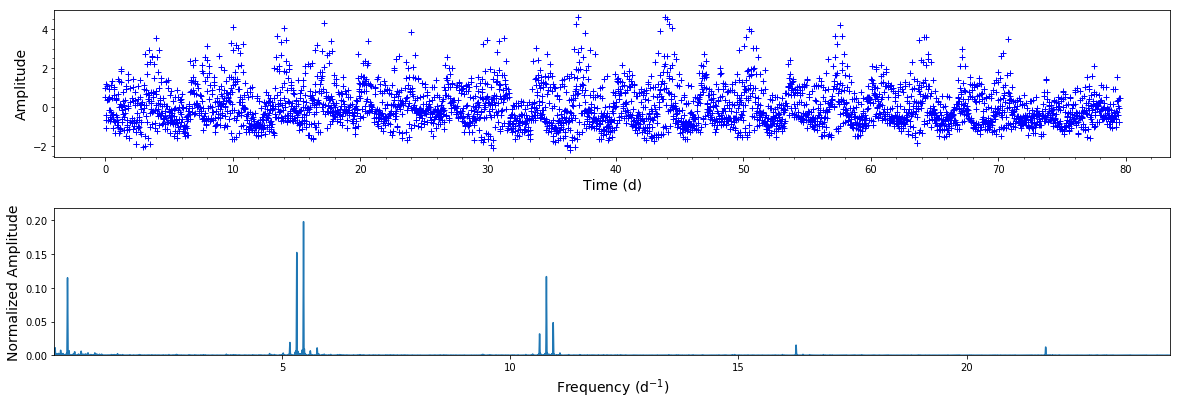

In [10]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# set height threshold for finding peaks 
phlim = fap_x[-1]

# change plot dimensions
plt.rcParams["figure.figsize"] = (20,10)

# show individual Gaussian fitting peak plots
show_plots = False
#show_plots = True
###############################################

fcount = 5 # increment output file counter

# import specific packages needed here
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# define Gaussian fitting function
def gaussfunc(gx,ga,gx0,gsigma):
    return ga*np.exp(-(gx-gx0)**2/(2*gsigma**2))

if LDEBUG >= 2: 
    # write peak finding/fitting results to output file
    fname1 = SAVEPATH+name_string+'_'+strfcount(fcount)+'_periodogram_peaks_trials_'+str(Np)+'.txt'
    outfile1 = open(fname1, 'w')

    # write peak finding/fitting results to output file in an alternate format
    fname2 = SAVEPATH+name_string+'_'+strfcount(fcount)+'_periodogram_peaks_periods_trials_'+str(Np)+'.txt'
    outfile2 = open(fname2, 'w')

# visualize the unfolded light curve data (diagnostic only - not intended for publication)
plt.subplots_adjust(hspace=0.35)
plt.subplot(3, 1, 1)
plt.plot(x-x[0], y, 'b+')
plt.xlabel('Time (d)', size=pfontsize1)
plt.ylabel('Amplitude', size=pfontsize1)
plt.minorticks_on()

# visualize the periodogram (diagnostic only - not intended for publication)
plt.subplots_adjust(hspace=0.35)
plt.subplot(3, 1, 2)
plt.plot(f, npgram)
plt.xlabel('Frequency (d$^{-1}$)', size=pfontsize1)
plt.ylabel('Normalized Amplitude', size=pfontsize1)
plt.axis([fmin, fmax, 0, 1.1*max(npgram)])

# find peaks in the periodogram using height threshhold from FAP plot (above)
peaks, _ = find_peaks(npgram, height=phlim)

if LDEBUG >= 2: 
    for i in range(len(peaks)):
        print(peaks[i], '  ', f[peaks[i]], '  ', 1.0/f[peaks[i]], '  ', npgram[peaks[i]])

if LDEBUG >= 2: 
    message = 'Results of Gaussian fits to periodogram peaks'
    print(message)
    print(message, file=outfile1)

# define DataFrame for holding periodogram peaks info
peaks_colnames = ['j', 'kmin', 'kmax', 'npts', 'height', 'center', 'sigma', 'HWHM', 'period', 'unc', 'FAP-confidence']
df_pd_peaks = pd.DataFrame(columns=peaks_colnames)

# Start the peak-fitting process
if show_plots == False:
    if LDEBUG >= 2: 
        message1 = '    j  kmin  kmax  npts  height     center     sigma      HWHM       period     unc         FAP-confidence'
        print(message1)
        print(message1, file=outfile1)

if LDEBUG >= 2:
    print(fap_levels)
    print(fap_x)

# Loop through the identified peaks
peak_fit_center = []
for i in range(len(peaks)):
    j = peaks[i]
    
    # assign FAP score
    for ii in range(len(fap_x)):
        if LDEBUG >= 2: print(ii, j, npgram[j], fap_x[ii], fap_levels[ii])
        if npgram[j] >= fap_x[ii]:
            fap_out = '>'+str(f"{fap_levels[ii]*100:.2f}")+'%'
            break

    # Find range around peak for the Gaussian fit (start at peak and count points 
    # in both directions until the "next" point is higher than the current one)
    # find range shortward of peak
    kmin = j
    while npgram[kmin-1] < npgram[kmin]:
        kmin = kmin-1
    # find range longward of peak
    kmax = j
    while npgram[kmax+1] < npgram[kmax]:
        kmax = kmax+1
    kmax += 1
    
    # define sub-arrays for Gaussian fitting
    gx = f[kmin:kmax]
    gy = npgram[kmin:kmax]
    gn = len(gx)                          
    gmean = sum(gx*gy)/sum(gy)               
    gsigma = np.sqrt(sum(gy * (gx - gmean)**2) / sum(gy))
    
    # perform Gaussian fitting and recover fit parameters
    popt,pcov = curve_fit(gaussfunc,gx,gy,p0=[npgram[j],gmean,gsigma])
    if LDEBUG >= 2: 
        print([npgram[j],gmean,gsigma])
        print(popt)
    rampl = round(popt[0],8)
    rcent = round(popt[1],8)
    rsigm = round(popt[2],8)
    rhwhm = round(rsigm*np.sqrt(2.0*np.log(2.0)),8)
    
    rperd = round(1.0/popt[1],8)
    rpunc = round(((rsigm*np.sqrt(2.0*np.log(2.0)))/popt[1] * (1.0/popt[1])), 8)
    
    peak_fit_center.append(rcent)
    
    # optionally show zoomed plots of individual peaks with overlaid Gaussian fitting results
    if show_plots == True:
        plt.subplot(3, 1, 3)
        plt.plot(f, npgram)
        plt.xlabel('Frequency (d$^{-1}$)', size=pfontsize1)
        plt.ylabel('Normalized Amplitude', size=pfontsize1)
        plt.axis([f[kmin-10], f[kmax+10], 0, 1.1*max(npgram[kmin:kmax])])
        if LDEBUG >= 2: 
            print(f[kmin-10], f[kmax+10], 0, 1.1*max(npgram[kmin:kmax]))
            for ii in peaks:
                plt.plot(f[ii], npgram[ii], "rx")
        plt.plot(gx,gaussfunc(gx,*popt),'ro:',label='fit')
        plt.pause(0.01)
        if LDEBUG >= 1: print(message1)
    
    if LDEBUG >= 2: 
        message = "{:5d} {:5d} {:5d} {:5d}  {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {}".format(j, kmin, kmax, kmax-kmin, rampl, rcent, rsigm, rhwhm, rperd, rpunc, fap_out)
        print(message)
    
    # append fit parameters to DataFrame
    df_params = [int(j), int(kmin), int(kmax), int(kmax-kmin), rampl, rcent, rsigm, rhwhm, rperd, rpunc, fap_out]
    df_pd_peaks = df_pd_peaks.append(pd.Series(df_params, index=df_pd_peaks.columns), ignore_index=True)
    
    if LDEBUG >= 2:
        pcnt = str(i)
        if i < 10: pcnt = '0'+pcnt
        pcnt = pcnt+' ='
        if rperd < 100: pcnt = pcnt+' '
        if rperd < 10: pcnt = pcnt+' '
        message2 = "{} {:.8f} {} {:.8f} {} {:.8f} {} {:.8f} {} {:.8f} {}".format('period'+pcnt, rperd, ' # unc =', rpunc, ' h =', rampl, ' freq =', rcent, ' HWHM =', rhwhm, fap_out)
        print(message, file=outfile1)
        print(message2, file=outfile2)

# restore default plot dimensions
plt.rcParams["figure.figsize"] = (12,6)

# restore default plot size
plt.rcParams["figure.figsize"] = PSIZE_DEFAULT

if LDEBUG >= 2:
    # close output files
    outfile1.close()
    outfile2.close()

if LDEBUG >= 0:
    print(df_pd_peaks)
    print('*** Finished identification and gaussian fits of periodogram peaks')

---
# Visualize periodogram with expanded scale and identified peaks

*** Finished plotting periodogram peaks


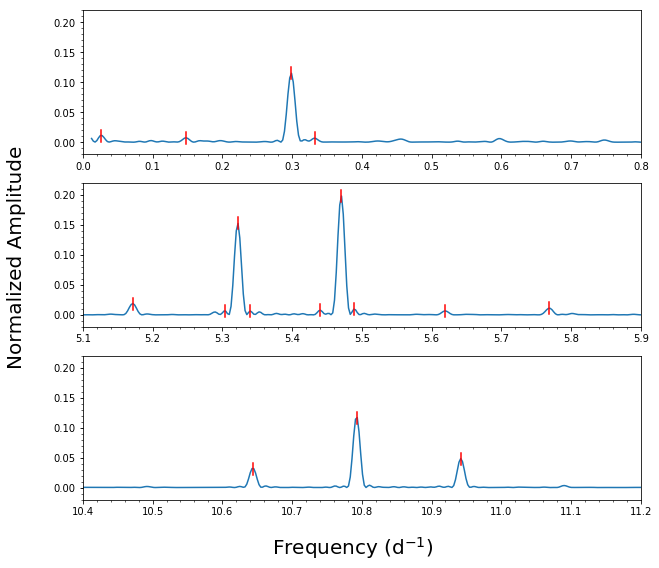

In [11]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# number of panels to show
npanels = 3

# update this dictionary to include settings for each panel
#    xmin, xmax = minimum, maximum frequency to plot
#    ymin, ymax = minimum, maximum power to plot
#    y_minor_tick = size of y-axis minor tick intervals
if tidx == 0:
    panparms = ( {
    'xmin':[0.0,  5.1, 10.4],
    'xmax':[0.8,  5.9, 11.2],
    'ymin':[0.0,  0.0,  0.0],
    'ymax':[0.20, 0.20, 0.20],
    'y_minor_tick':[0.010, 0.010, 0.010]
    } )
if tidx == 1:
    panparms = ( {
    'xmin':[0.0,  5.1, 10.4],
    'xmax':[0.8,  5.9, 11.2],
    'ymin':[0.0,  0.0,  0.0],
    'ymax':[0.005, 0.005, 0.005],
    'y_minor_tick':[0.001, 0.001, 0.001]
    } )
###############################################

fcount = 6 # increment output file counter

# handle obvious error(s)
if tidx > len(tname)-1:
    if LDEBUG >= 0: print('ERROR: No plot window settings defined')

# set up the multipanel plot
fig, axes = plt.subplots(npanels, 1, figsize=(10,npanels*3))

# centered common axis labels
fig.text(0.5, 0.04, 'Frequency (d$^{-1}$)', ha='center', size=pfontsize2)
fig.text(0.02, 0.5, 'Normalized Amplitude', va='center', rotation='vertical', size=pfontsize2)

# set font size for axis tick labels
plt.rc('xtick', labelsize=pfontsize1) 
plt.rc('ytick', labelsize=pfontsize1) 

# loop over panels
for i, ax in enumerate(axes.flatten()):
    # plot data into current panel
    if LDEBUG >= 2: print(i, ax)
    ax.plot(f, npgram)

    # plot decorations
    pstep = panparms['y_minor_tick'][i]
    ax.axis([panparms['xmin'][i], panparms['xmax'][i], panparms['ymin'][i]-2*panparms['y_minor_tick'][i], panparms['ymax'][i]+2*panparms['y_minor_tick'][i]], fontsize=pfontsize1)
    ax.minorticks_on()
    ax.yaxis.set_minor_locator(MultipleLocator(panparms['y_minor_tick'][i]))
    
    # plot markers for the gaussian fit peak centers from the previous cell
    for ii in range(len(peak_fit_center)):
        j = peaks[ii]
        if LDEBUG >= 2: print(j, peaks[ii], npgram[j])
        if npgram[j] >= fap_x[2]:
            ax.plot([peak_fit_center[ii],peak_fit_center[ii]], [npgram[j]-pstep,npgram[j]+pstep], color='red')

# output the visualization
plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_LSperiodogram_panels.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0: 
    print('*** Finished plotting periodogram peaks')

---
# Calculate the phases for all periods
Converts data time values into phases corresponding to all of the periodogram peaks identified above

In [12]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# OPTIONAL phase offset to add to calculated phases
phi_offset = 0.0

# OPTIONAL time zeropoint for calculating phases (-1 to use first time)
phi_zeropoint = -1
###############################################

if phi_zeropoint < 0: phi_zeropoint = df_lc_clean.time.to_numpy()[0]

if LDEBUG >= 2: 
    print('phi_zeropoint =', phi_zeropoint)
    print(df_lc_clean.time.to_numpy())

# loop over periods
for i in range(len(df_pd_peaks.period)):
    colname = str(i)
    #if i < 100: colname = '0'+colname
    if i < 10: colname = '0'+colname
    colname = 'phi'+colname
    
    if LDEBUG >= 2: 
        print(colname)
        print(df_pd_peaks.period.to_numpy()[i])
    
    # add new column for each set of phases to existing DataFrame
    df_lc_clean[colname] = (df_lc_clean.time.to_numpy() - phi_zeropoint)/df_pd_peaks.period.to_numpy()[i] + phi_offset
        
if LDEBUG >= 2: print(df_lc_clean)

if LDEBUG >= 0:
    print('*** Finished calculating phases')

*** Finished calculating phases


---
# Phase binning
Average the phases for a user-selected period into a user-defined number of bins per cycle. The result is a binned light curve for each cycle of the period, and a final "average" light curve for the entire phase-folded data set for the period.

In [13]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# step size for phase bins (1/dstep should be an integer)
dstep = 0.10

# select period from list of periods defined above (df_pd_peaks.periods)
pidx = 8
###############################################

# function to truncate a number to keep only the decimal part (used with phase calculations)
def mphi(p):
    return p-int(p)

# half of a phase bin width
dshift = dstep/2.0
# number of phase bins
nphibins = int(1.0/dstep)

if LDEBUG >= 1: print('nphibins = ',nphibins)

# calculate phase bin starting points
pbins = [(0.0 + dstep*x)-(dstep/2.0) for x in range(nphibins+1)]
pbins[0] = pbins[0]+1.0
pbins = [round(i,3) for i in pbins]

if LDEBUG >= 2: print(pbins)

# calculate centers of phase bins
pcbins = [(0.0 + dstep*x) for x in range(nphibins)]
pcbins.append(pcbins[0]+1.0)
pcbins = [round(i,3) for i in pcbins]

if LDEBUG >= 1: print('Bin centers:', pcbins)

# sort data into phase bins
spidx = str(pidx)
if pidx < 10: spidx = '0'+spidx
p = np.copy(df_lc_clean['phi'+spidx])
a = np.copy(df_lc_clean['varflux'])

# define new DataFrame to store phase-binned data
phi_colnames1 = [str(i) for i in pcbins]
phi_colnames2 = [str(i+1) for i in pcbins]
phi_colnames = phi_colnames1 + phi_colnames2[1:]
df_lc_clean_bin = pd.DataFrame(columns=phi_colnames)

if LDEBUG >= 2: print(df_lc_clean_bin)

# running sum for each phase bin for all cycles
allbinsum = [0.0 for i in range(nphibins)]
# running total of data points summed into each phase bin for all cycles
allbinnum = [0 for i in range(nphibins)]
# average in each phase bin for all cycles (default is Nan)
allbinavg = [np.nan for i in range(nphibins)]
    
# loop over all phase cycles in input data
for i in range(int(np.floor(max(p)))):
    # running sum for each phase bin for one cycle
    binsum = [0.0 for i in range(nphibins)]
    # running total of data points summed into each phase bin for one cycle
    binnum = [0 for i in range(nphibins)]
    # average in each phase bin for one cycle (default is Nan)
    binavg = [np.nan for i in range(nphibins)]
    
    subp = p[(p >= i) & (p < i+1)]
    suba = a[(p >= i) & (p < i+1)]    
    
    if len(subp) > 0:
        if LDEBUG >= 2: 
            print(subp)
            print(suba)
        
        # truncate phases to keep just decimal part
        subpdec = [mphi(ii) for ii in subp]
        
        # loop over all phase bins
        for j in range(nphibins):
            # sort appropriate data into current phase bin
            for k in range(len(subp)):
                if (mphi(subpdec[k]+dshift) >= pcbins[j] and mphi(subpdec[k]+dshift) < pcbins[j+1]):
                    allbinsum[j] += suba[k]
                    allbinnum[j] += 1
                    binsum[j] += suba[k]
                    binnum[j] += 1
                    if LDEBUG >= 2:
                        print('i, j, k:', i, j, k)
                        print('pcbins[j], pcbins[j+1], mphi(subpdec[k]+dshift):', pcbins[j], pcbins[j+1], mphi(subpdec[k]+dshift))
                        print('binsum, binnum:', binsum[j], binnum[j])
                        print('allbinsum, allbinnum:', allbinsum[j], allbinnum[j])
            # calculate average value in current bin
            if binnum[j] > 0: binavg[j] = binsum[j]/binnum[j]
        
        # append copy of phase bin averages to provide two cycles of phased data
        for ii in range(nphibins):
            binavg.append(binavg[ii])
        binavg.append(binavg[0])

        if LDEBUG >= 2: print(binsum, binnum, binavg)
        
        # store average phase bin values for this cycle in a row of the dataframe
        df_lc_clean_bin = df_lc_clean_bin.append(pd.Series(binavg, index=df_lc_clean_bin.columns), ignore_index=True)
    else:
        if LDEBUG >= 0: print('***ERROR: no data for phase cycle', i)

    if LDEBUG >= 2:
        print('\n')
        print('===========================================================')
        print('\n')

# calculate average value in phase bins for all cycles
for j in range(nphibins):
    if allbinnum[j] > 0: allbinavg[j] = allbinsum[j]/allbinnum[j]
        
# append copy of phase bin averages to provide two cycles of phased data
for ii in range(nphibins):
    allbinavg.append(allbinavg[ii])
allbinavg.append(allbinavg[0])        

# store average phase bin values for all cycles in last row of the DataFrame
# This is the "average" light curve for each period
df_lc_clean_bin = df_lc_clean_bin.append(pd.Series(allbinavg, index=df_lc_clean_bin.columns), ignore_index=True)

if LDEBUG >= 2:
    print('\n')
    print(df_lc_clean_bin)

if LDEBUG >= 0: 
    print('\n')
    print('*** Finished phase binning')

nphibins =  10
Bin centers: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


*** Finished phase binning


---
# 2D LIGHT CURVE
Visualize the data as a 2-dimensional light curve (X = phase, Y = cycles)

*** Finished displaying 2-dimensional trailed light curves


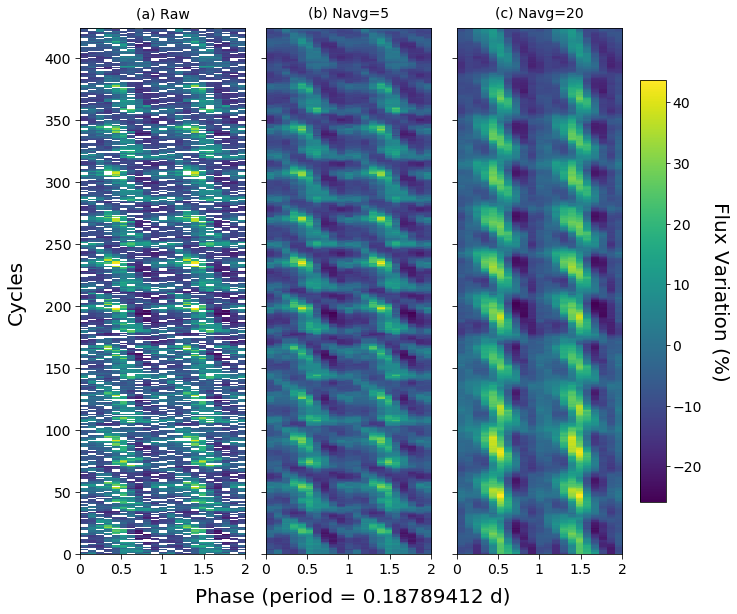

In [14]:
###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# Select size(s) of the moving window for smoothing (number of cycles, [min, max])
# Set min to be the smallest number that eliminates all Nans (white pixels) in the visualization
wroll = [ 5, 20]

# color map name
pcmap = 'viridis'
#pcmap = 'plasma'
#pcmap = 'magma'
#pcmap = 'inferno'
#pcmap = 'cividis'

# aspect ratio (1.0 = 1:1)
pasp = 0.015
###############################################

fcount = 7 # increment output file counter

# define the number of rows in the visualization image
numrows = len(df_lc_clean_bin.index)

# set up the multipanel visualization
gs_kw=dict(wspace=0.02)
fig, axN = plt.subplots(1,3, sharey=True, figsize=(9.6,8), constrained_layout=True, gridspec_kw=gs_kw)

# offsets for axis labels
plxpos = [ 0.45, -0.04]
plypos = [-0.05 ,  0.50]

# common axis labels shared by subplot panels
fig.text(plxpos[0], plxpos[1], 'Phase (period = '+str(df_pd_peaks.period[pidx])+' d)', ha='center', size=pfontsize2)
fig.text(plypos[0], plypos[1], 'Cycles', va='center', rotation='vertical', size=pfontsize2)

# Visualize the data as a 2-dimensional light curve
# Three panels show: (1) raw data, (2 & 3) data smoothed by a moving window average (window widths defined above)
imethod = 'none'
for i in range(0,3):
    # make new DataFrame for working in
    df_lc_clean_binavg = df_lc_clean_bin.copy()
    # convert amplitudes to percentage variability
    for colname in phi_colnames:
        df_lc_clean_binavg[colname] = 100.0*(df_lc_clean_bin[colname] - varflux_mean) / varflux_mean
    
    # apply moving window smoothing
    if i >= 1:
        for colname in phi_colnames:
            df_lc_clean_binavg[colname] = df_lc_clean_binavg[colname].rolling(window=wroll[i-1], min_periods=1, center=True).mean()

    # label subplots
    if i == 0:
        ltitle = 'Raw'   # Missing data (Nans) are visualized in white
    else:
        ltitle = 'Navg='+str(wroll[i-1])

    # visualize data into subplots
    im = axN[i].imshow(df_lc_clean_binavg,aspect=pasp,origin='lower',extent=[0.0,2.0,0,numrows],interpolation=imethod,cmap=pcmap)
    
    # format and label tickmarks
    axN[i].tick_params(labelsize=pfontsize1, length=5)
    axN[i].set_xticks((0, 0.5, 1, 1.5, 2))
    axN[i].set_xticklabels(('0','0.5','1','1.5','2'))
    axN[i].set_title('('+abclabels[i]+') '+ltitle, fontsize=pfontsize1, pad=10)

    # display color bar
    if i == 2:
        cbar = fig.colorbar(im, ax=axN[i], shrink=0.8)
        cbar.ax.tick_params(labelsize=pfontsize1)
        cbar.set_label('Flux Variation (%)', fontsize=pfontsize2, labelpad=28, rotation=270)

# output the visualization
fig.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_trailed_'+str(df_pd_peaks.period[pidx])+'.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0: 
    print('*** Finished displaying 2-dimensional trailed light curves')

# REFERENCES

## General

1. Command continuation on multiple lines:
    - https://stackoverflow.com/questions/17076710/python-split-statement-into-multiple-lines
1. Comparison of interpolation methods:
    - https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/interpolation_methods.html#sphx-glr-gallery-images-contours-and-fields-interpolation-methods-py
1. Gaussian fit:
    - https://stackoverflow.com/questions/19206332/gaussian-fit-for-python
1. Multiprocessing:
    - https://www.praetorian.com/blog/multi-core-and-distributed-programming-in-python?edition=2019
1. Robust random numbers (use SystemRandom):
    - https://smallbusiness.chron.com/randomize-list-python-26724.html


## Periodogram

1. Cumulative distribution plot:
    - https://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python
1. Confidence level examples:
    - https://www-zeuthen.desy.de/students/2017/Summerstudents2017/reports/GiulianaNoto.pdf (Section 3.4)
1. False Alarm Probability (FAP)
    - https://arxiv.org/pdf/1703.09824.pdf (Bootstrapping the FAP; Section 7.4.2)
    - https://mail.python.org/pipermail//astropy/2016-June/003937.html
1. Non-Uniform Nyquist Limit:
    - https://arxiv.org/pdf/1703.09824.pdf (Section 4.1.2)
1. Normalization:
    - https://github.com/scipy/scipy/issues/2162
1. Number of periodogram frequencies:
    - https://arxiv.org/pdf/1703.09824.pdf (Section 7.1)


## Plotting in Python

1. Annotation (matplotlib.pyplot.annotate):
    - https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.annotate.html
1. Axis labels:
    - https://stackoverflow.com/questions/33283601/manually-defined-axis-labels-for-matplotlib-imshow/33283892
1. Colorbars:
    - https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
    - https://stackoverflow.com/questions/40184696/change-fontsize-of-colorbars-in-matplotlib
1. Colormaps:
    - https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
1. Multipanel plot using a FOR loop
    - https://stackoverflow.com/questions/42845887/how-to-run-a-smart-loop-for-subplots-in-python
1. Spacing of subplots:
    - https://stackoverflow.com/questions/37864735/matplotlib-and-ipython-notebook-displaying-exactly-the-figure-that-will-be-save
    - https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib    
1. Tick font size in subplots:
    - https://stackoverflow.com/questions/38369188/set-size-of-ticks-in-all-subplots
1. Tick parameters:
    - https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.axes.Axes.tick_params.html
1. Titles:
    - https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle


# DEPRECATED CELLS BELOW HERE

### I'm still working on these ones...

### L-S Periodogram results for primary target (SAP data)

height     |frequency   |HWHM       |period      |uncertainty |FAP-confidence |Identification
-----------|------------|-----------|------------|------------|---------------|---------------
0.01042072 | 0.02686826 |0.00452284 |37.21864217 |6.26516708  |>99.73%        |
0.00746887 | 0.14787698 |0.00595141 |6.76237763  |0.27215638  |>95.45%        | (s-o) = 0.14831066 (beat)
0.12133518 | 0.29876237 |0.00613109 |3.34714179  |0.06868882  |>99.73%        |2(s-o) = 0.29662132
0.00620124 | 0.33290648 |0.00564914 |3.00384663  |0.05097275  |>90.00%        |
0.00805273 | 0.59768136 |0.00667656 |1.67313231  |0.01869018  |>95.45%        |4(s-o) = 0.59324265
0.02046610 | 5.17162533 |0.00604744 |0.19336281  |0.00022611  |>99.73%        |2o - s = 5.1738410
0.00604823 | 5.30327179 |0.00318854 |0.18856284  |0.00011337  |>68.27%        |
0.15916744 | 5.32215166 |0.00551646 |0.18789393  |0.00019475  |>99.73%        |o (orbit)
0.00575038 | 5.34030254 |0.00299313 |0.18725531  |0.00010495  |>68.27%        |
0.00583585 | 5.35347730 |0.00366114 |0.18679448  |0.00012775  |>68.27%        |
0.00824249 | 5.44012019 |0.00417690 |0.18381947  |0.00014114  |>99.73%        |
0.19915756 | 5.47046225 |0.00568197 |0.18279991  |0.00018987  |>99.73%        |s (spin)
0.00965358 | 5.48971573 |0.00353928 |0.18215879  |0.00011744  |>99.73%        |
0.01122384 | 5.76898908 |0.00575909 |0.17334060  |0.00017304  |>99.73%        |3s-2o  = 5.7670832
0.03152549 |10.64383961 |0.00557638 |0.09395106  |0.00004922  |>99.73%        |2o     = 10.644303
0.12175030 |10.79239150 |0.00562013 |0.09265787  |0.00004825  |>99.73%        | (s+o) = 10.792614
0.04996560 |10.94189330 |0.00568209 |0.09139186  |0.00004746  |>99.73%        |2s     = 10.940925
0.01483830 |16.26441601 |0.00569277 |0.06148392  |0.00002152  |>99.73%        |2s + o = 16.263077
0.01267788 |21.73386808 |0.00582333 |0.04601114  |0.00001233  |>99.73%        |3s + o = 21.733538


In [ ]:
# Plot folded light curves

fcount = 6 # increment output file counter

###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# plot axis ranges [xmin, xmax, ymin, ymax]
if tidx == 0:
    paxvals = [0,1,-70,150]
if tidx == 1:
    paxvals = [0,1,-15,15]
###############################################

npanels = len(lc['period'])

# set up the multipanel plot
if npanels <= 4:
    fig, axes = plt.subplots(npanels, 1, sharex=False, figsize=(10,npanels*5))
    plxpos = [0.50, 0.09]
    plypos = [0.02, 0.50]
else:
    fig, axes = plt.subplots(int(np.ceil(npanels/2)), 2, sharex=False, figsize=(20,npanels*2.5))
    plxpos = [0.50, 0.08]
    plypos = [0.08, 0.50]

# increase buffer space between subplot panels
plt.subplots_adjust(hspace=0.3)

# centered common axis labels
fig.text(plxpos[0], plxpos[1], 'Phase', ha='center', size=pfontsize2)
fig.text(plypos[0], plypos[1], 'Flux Variation (%)', va='center', rotation='vertical', size=pfontsize2)

# set font size for axis tick labels
plt.rc('xtick', labelsize=pfontsize1) 
plt.rc('ytick', labelsize=pfontsize1) 

if LDEBUG >= 2: print(x[0:10])

# loop over panels
for i, ax in enumerate(axes.flatten()):
    # bail out if there is an odd number of panels in multicolumn format
    if i+1 > npanels:
        ax.set_visible(False)
        break

    # plot data into current panel
    if LDEBUG >= 2: print(i, ax)
    if LDEBUG >= 2: print(lc['phi'][i][0:10])
    ax.errorbar(lc['phi'][i], y0, barsabove=True, color='k', marker='o', markersize='2', linewidth=0, elinewidth=0)

    # plot decorations
    ax.axis(paxvals)
    ax.minorticks_on()
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.set_title('Period = '+lc['speriod'][i], fontsize=pfontsize1, pad=10)

plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_folded.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0: 
    print('\n')
    print('*** Finished plotting folded light curves')

# REFERENCES
# error bars:
# https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.errorbar.html

# make a subplot invisible
# https://stackoverflow.com/questions/14694501/delete-a-subplot

In [ ]:
# Plot folded light curves with time sequence split data

fcount = 7 # increment output file counter

###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# which period from pdlist to yuse?
pidx = 0

# plot axis ranges [xmin, xmax, ymin, ymax]
if tidx == 0:
    paxvals = [0,1,-70,150]
if tidx == 1:
    paxvals = [0,1,-15,15]

# number of plot panels (equivalenet to number of time intervals to split data into)
npanels = 6
###############################################

if LDEBUG >= 1: print('Period = '+lc['speriod'][pidx])

# import specific packages
import string
import pylab

# set up the multipanel plot
fig, axes = plt.subplots(int(npanels/2), 2, sharex=False, figsize=(10,npanels*1.5))

# centered common axis labels
fig.text(0.5, 0.04, 'Phase', ha='center', size=pfontsize2)
fig.text(0.04, 0.5, 'Flux Variation (%)', va='center', rotation='vertical', size=pfontsize2)

# set font size for axis tick labels
plt.rc('xtick', labelsize=pfontsize1) 
plt.rc('ytick', labelsize=pfontsize1) 

# define x (phi) array for splitting
xtemp = lc['phi'][pidx]
nx = len(xtemp)
nxsplit = int(nx/npanels)
panel_labels = list(string.ascii_lowercase)
if LDEBUG >= 2: print(nx, nxsplit)
    
# loop over panels
for i, ax in enumerate(axes.flatten()):
    # plot data into current panel
    if LDEBUG >= 2: print(i, ax)
    
    splitidx = list(range(i*nxsplit, (i+1)*nxsplit))
    
    ax.errorbar(xtemp[splitidx], y[splitidx], barsabove=True, color='k', marker='o', markersize='2', linewidth=0, elinewidth=0)

    # plot decorations
    ax.axis(paxvals)
    ax.minorticks_on()
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.set_title('('+panel_labels[i]+')', fontsize=pfontsize1, pad=10)

plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_folded_time_split.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0: 
    print('\n')
    print('*** Finished plotting folded light curves')

# REFERENCES
# error bars:
# https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.errorbar.html

# centered common axis labels
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots

In [ ]:
# Overplot cycle-averaged folded light curves

fcount = 8 # increment output file counter

###############################################
# CUSTOMIZE ANY OF THESE AS NEEDED!!!

# number of cycles to average per light curve
navg = 4

# which entry in lc dictionary to use
idx = 0
###############################################

if LDEBUG >= 2:
    print(lc)
    print(lc['ncycles'][idx]//navg)
    print(lc['phi'][idx][10])

philist = []
for k in range(lc['ncycles'][idx]//navg):
    phisum = [0.0 for x in range(len(pbins)-1)]
    phinum = [0 for x in range(len(pbins)-1)]
    p_lo_lim = phi_int_min+(k*navg)-dshift
    p_hi_lim = phi_int_min+((k+1)*navg)-dshift
    for i in range(len(x)):
        if LDEBUG >= 2: print('A: ',k, i, lc['phi0'][idx][i], p_lo_lim, p_hi_lim, ' - new data point')
        if lc['phi0'][idx][i] >= p_lo_lim and lc['phi0'][idx][i] < p_hi_lim:
            for j in range(len(pbins)-1):
                temp_sum = 0.0
                if LDEBUG >= 2: print('B: ',k,i,j,phi[i],pbins[j],pbins[j+1], ' - look for phase bin match')
                tphi0 = lc['phi'][idx][i]+dshift
                tphi = tphi0 - int(tphi0)
                p_lo = pbins[j]+dshift
                p_lo = p_lo - int(p_lo)
                if tphi >= p_lo:
                    p_hi = pbins[j+1]+dshift
                    p_hi = p_hi - int(p_hi)
                    if p_hi == 0.0:
                        p_hi = 1.00
                    if tphi < p_hi:
                        if LDEBUG >= 2: print('b: ',k,i,j,lc['phi'][idx][i],lc['phi'][idx][i]+dshift,tphi,p_lo,p_hi, ' - look for phase bin match')
                        temp_sum += y[i]
                        if LDEBUG >= 2: print('C: ',k,i,j,lc['phi'][idx][i],pbins[j],pbins[j+1],y[i],temp_sum, ' - increment phase bin sum and counter')
                        phisum[j] += temp_sum
                        phinum[j] += 1
                        if LDEBUG >= 2: print('D: ',k,i,j,phisum,phinum)
                        break
        elif lc['phi0'][idx][i] >= p_hi_lim:
            break

    if LDEBUG >= 2:
        print(k,i,j)
        print(phisum)
        print(phinum)
    
    phidiv = [(ii/jj) for ii, jj in zip(phisum, phinum)] 
    if LDEBUG >= 2: print(ii, jj, phidiv)
    phidiv.append(phidiv[0])
    philist.append(phidiv)
    
    # plot cycle-averaged folded light curves
    plt.errorbar(pcbins, philist[k], barsabove=True, color='k', marker='o', markersize='0', linewidth=1, elinewidth=0)

# calculate folded light curve averaged over all cycles
phimean = []
phierr = []
for i in range(nphibins):
    phitemp = []
    for j in range(lc['ncycles'][idx]//navg):
        if LDEBUG >= 2: print(philist[j][i])
        phitemp.append(philist[j][i])
    phimean.append(np.mean(phitemp))
    phierr.append(np.std(phitemp))
phimean.append(phimean[0])
phierr.append(phierr[0])

# plot folded light curve averaged over all cycles
plt.errorbar(pcbins, phimean, yerr=phierr, barsabove=True, color='r', marker='o', markersize='12', linewidth=3, elinewidth=3)

# plot decorations
plt.axis([0,1,-65,150])
plt.minorticks_on()
plt.xticks(fontsize=pfontsize1)
plt.yticks(fontsize=pfontsize1)
plt.xlabel('Phase (period = '+lc['speriod'][idx]+' d)',fontsize=pfontsize2, labelpad=10)
plt.ylabel('Flux Variation (%)', fontsize=pfontsize2, labelpad=20)

plt.savefig(SAVEPATH+name_string+'_'+strfcount(fcount)+'_lc_lines_'+lc['speriod_fname'][idx]+'.png',dpi=150, bbox_inches='tight')

if LDEBUG >= 0:
    print('\n')
    print('*** Finished plotting cycle-averaged light curves')

# REFERENCES
# error bars:
# https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.errorbar.html